In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


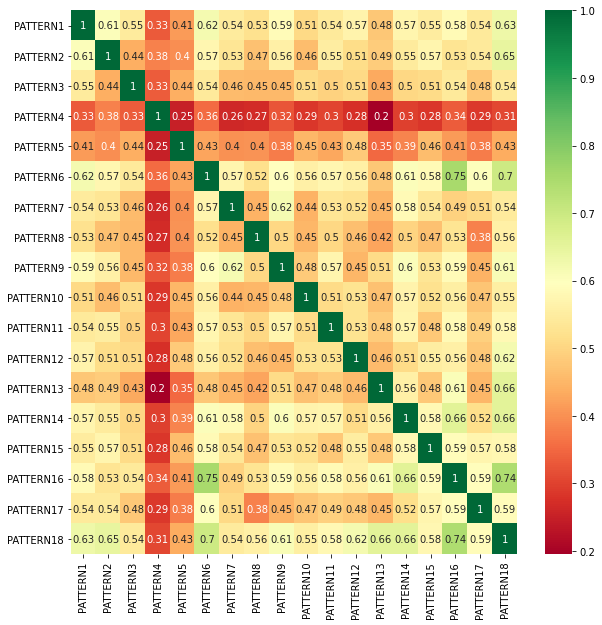

['DEMENZA' 'MCI' 'MCI ' 'NORMALI']
{0: array([  2,   3,   5,   6,   7,   8,  21,  24,  27,  30,  31,  32,  79,
        81,  82, 102, 104, 112, 121, 123, 124, 130, 137, 141, 149, 155,
       157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 172, 173,
       174, 175, 176, 179, 182, 187, 189, 190, 193, 199, 200, 201, 202,
       203, 204, 205, 206, 208, 210, 212, 216, 218, 220]), 1: array([  0,   1,   9,  10,  11,  12,  13,  15,  18,  19,  20,  22,  23,
        25,  26,  28,  33,  34,  35,  36,  37,  38,  41,  42,  43,  45,
        46,  49,  51,  52,  53,  54,  55,  57,  59,  60,  61,  63,  64,
        65,  67,  68,  70,  72,  73,  75,  76,  77,  78,  80,  83,  84,
        85,  86,  88,  89,  90,  91,  92,  93,  94,  98,  99, 100, 101,
       103, 105, 106, 107, 109, 111, 113, 114, 117, 118, 120, 125, 126,
       127, 128, 129, 131, 132, 133, 134, 135, 136, 138, 139, 140, 142,
       143, 144, 145, 146, 147, 150, 151, 152, 153, 154, 156, 164, 169,
       170, 171, 177, 178, 180, 181

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


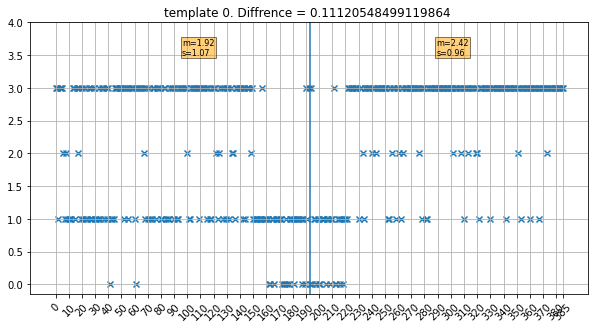

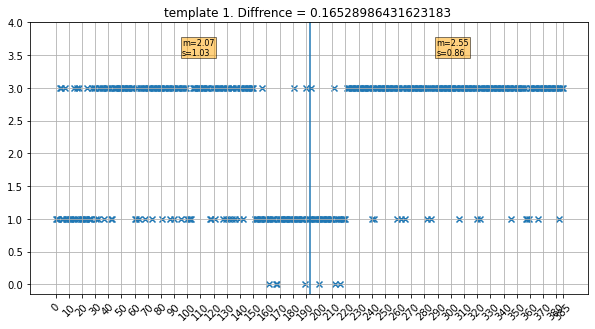

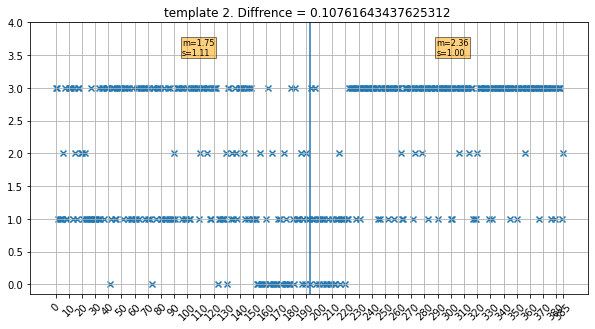

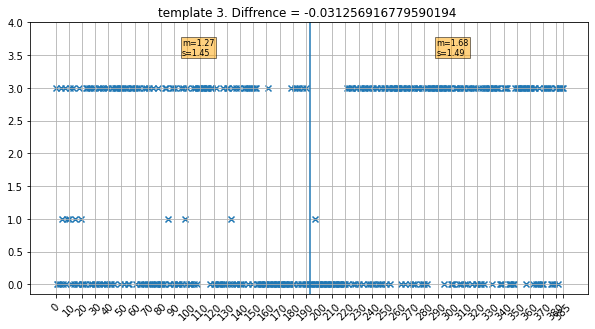

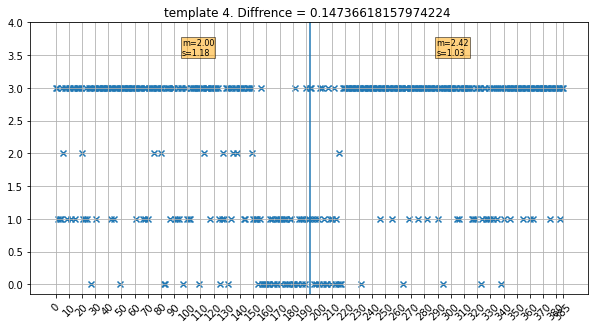

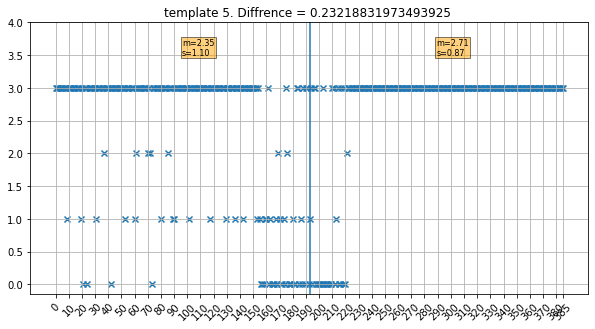

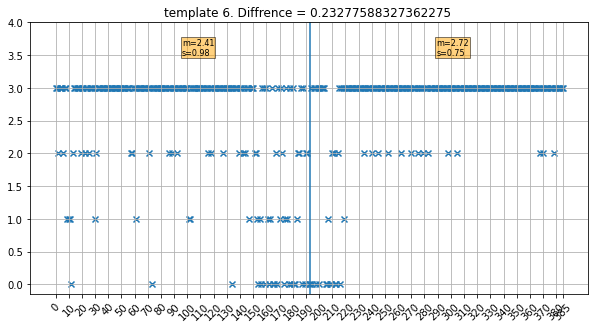

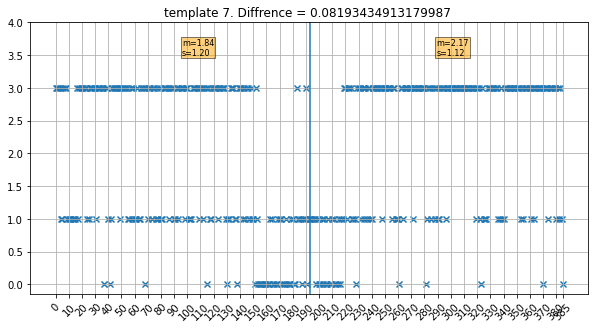

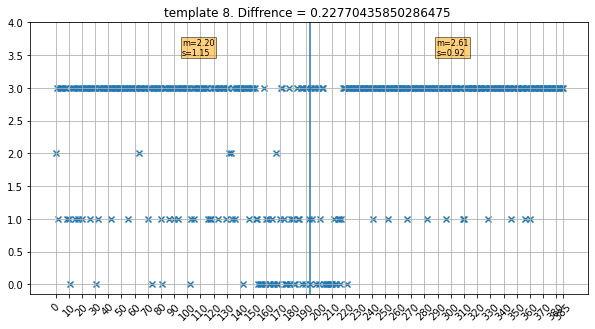

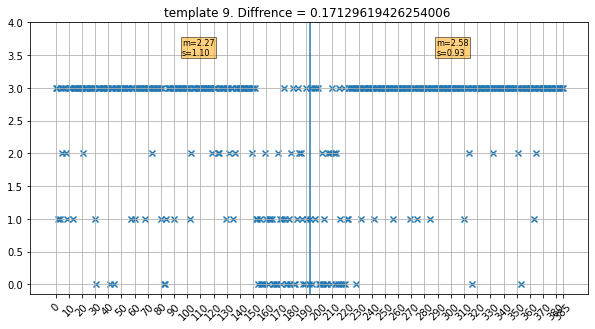

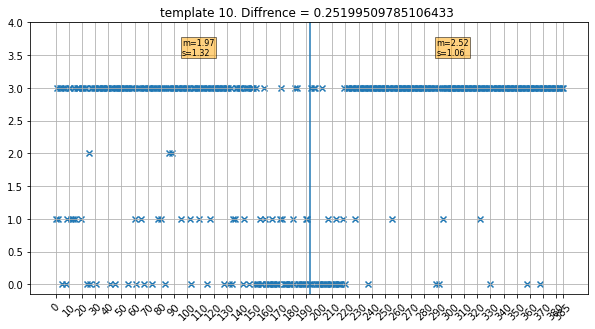

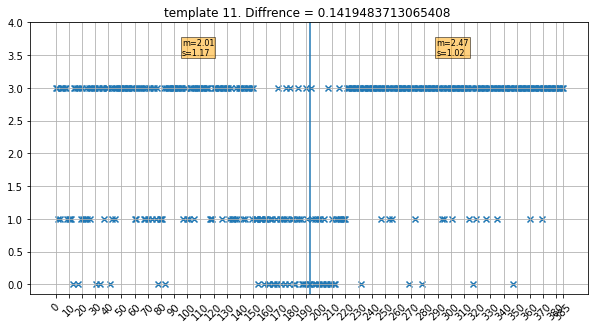

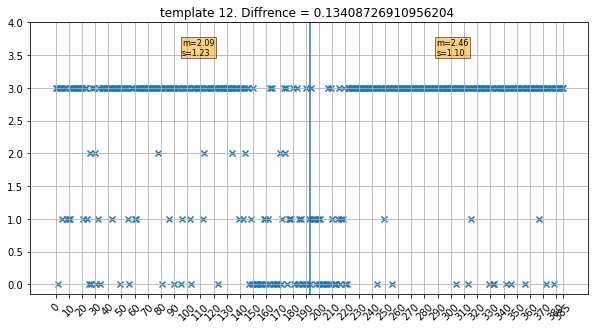

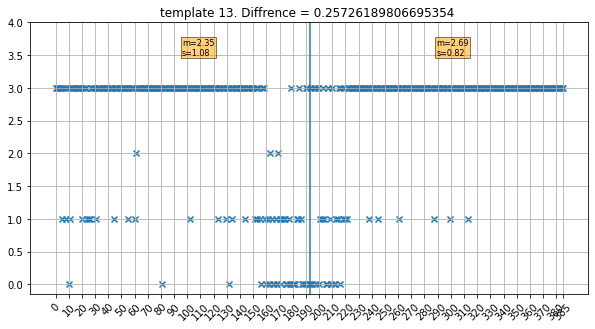

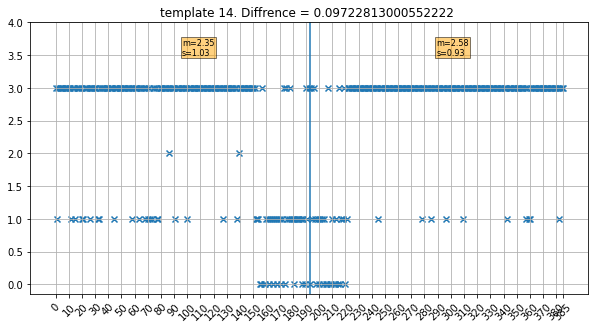

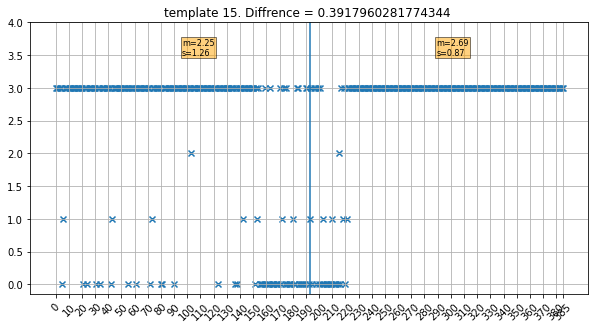

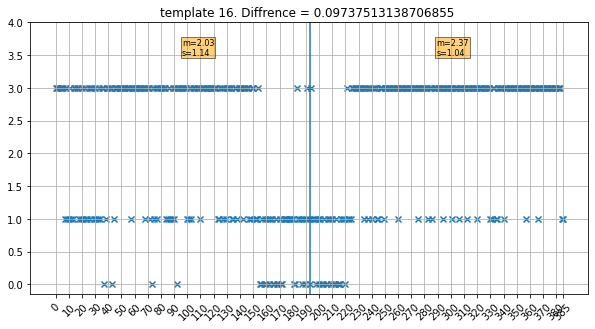

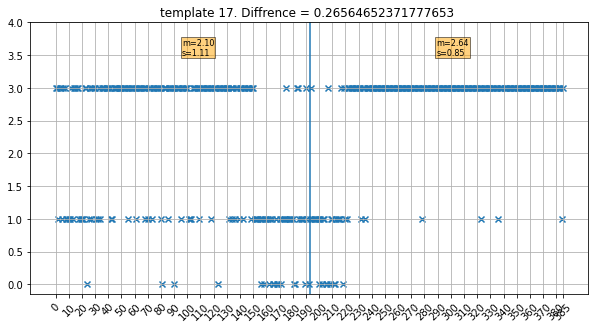

[ 6 10 13 17 15]
[0.23277588 0.2519951  0.2572619  0.26564652 0.39179603]
Classification accuracy without selecting features: 0.825
[ 0  1  2 10 17]
Classification accuracy after univariate feature selection: 0.804


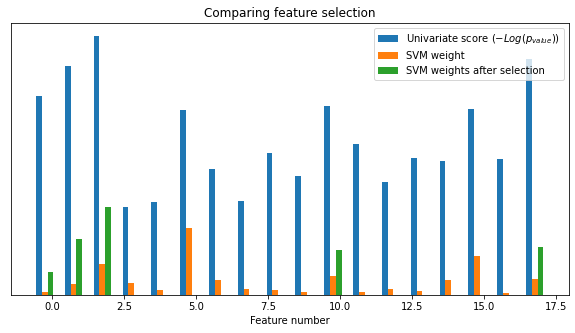

(289, 5)
(97, 5)
Classification accuracy after mine selection: 0.794


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import os 

def label(s):
    if s == 'NORMALI':
        return 0
    else:
        return 1
    

#per fare feature sel. sul dataset bilanciato, togliere # dove si trova e aggiungerlo dove indicato
root = './gdrive/My Drive/thesis' #modificare se cartella rinominata
#labels_name = [str(i) for i in range(19)]
#dataset = pd.read_csv(os.path.join(root, 'nuovo_dataset_bilanciato.csv'), names=labels_name)
dataset = pd.read_csv(os.path.join(root, 'bilanciato_abbate_3.csv'), header=0, index_col=0)
X = dataset.iloc[:, :-1].to_numpy()
#dataset_c = pd.read_csv(os.path.join(root, 'Database completo .csv'), header=0, index_col=0, delimiter=';') #aggiungere commento qui
#aggiungere commento qui
#normal_mci = dataset[dataset.iloc[:, -1] < 2]
corrmat = dataset.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
g = sns.heatmap(dataset[top_corr_features].corr(), annot=True, cmap="RdYlGn")
plt.show()
plt.close('all')

y = dataset.iloc[:, -1]
#aggiungere commento da qui...
unique = np.unique(y)
print(unique)
mapping = {}
for i in range(len(unique)):
     mapping[i] = np.where(y == unique[i])[0]
print(mapping)
for idx in mapping[2]:
    y[idx] = unique[1]
index_normal = y[y == 'NORMALI'].shape[0]
y = np.array(list(map(label, y)))
#... a qui (usare ''')

#index_normal = y[y < 1].shape[0]
patients = np.arange(dataset.shape[0], dtype=int)
differences = []
for template in range(X.shape[1]):
    labels = X[:, template]
    mean_normal = np.mean(labels[:index_normal])
    std_normal = np.std(labels[:index_normal])
    mean_mci = np.mean(labels[index_normal:])
    std_mci = np.std(labels[index_normal:])
    plt.figure(figsize=(10, 5))
    plt.scatter(patients, labels, marker='x')
    plt.xticks(np.append(patients[::10], patients[-1]), rotation=45)
    plt.ylim(top=4)
    plt.text(int(len(labels)/4), 3.5, 'm={:.2f}\ns={:.2f}'.format(mean_normal, std_normal),
             fontsize=8, bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 1})
    plt.text(int(3*len(labels) / 4), 3.5, 'm={:.2f}\ns={:.2f}'.format(mean_mci, std_mci),
             fontsize=8, bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 1})
    plt.axvline(x=index_normal)
    plt.title('template {}. Diffrence = {} '.format(template, std_normal-std_mci))
    plt.grid(True)
    plt.show()   
    plt.close('all')
    differences.append(np.abs(std_normal-std_mci))
top5 = np.argsort(differences)[-5:]
print(top5)
print(np.array(differences)[top5])
X_indices = np.arange(X.shape[-1])
best = 5
X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=0)
selector = SelectKBest(f_classif, k=best)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.figure(figsize=(10, 5))
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')
clf = make_pipeline(StandardScaler(), LinearSVC(class_weight='balanced'))
clf.fit(X_train, y_train)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(X_test, y_test)))
print(X_indices[selector.get_support()])
svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight')

clf_selected = make_pipeline(
        SelectKBest(f_classif, k=best), StandardScaler(), LinearSVC(class_weight='balanced')
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

clf_top5 = make_pipeline(StandardScaler(), LinearSVC(class_weight='balanced'))
X_top5_train = X_train[:, top5]
X_top5_test = X_test[:, top5]
print(X_top5_train.shape)
print(X_top5_test.shape)
clf_top5.fit(X_top5_train, y_train)
print('Classification accuracy after mine selection: {:.3f}'
      .format(clf_top5.score(X_top5_test, y_test)))

In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=5.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score no selection: 0.792377495462795
train score no selection: 0.8304498269896193
test score no selection: 0.8556701030927835

SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-5.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score selection: 0.7645493042952208
train score selection: 0.7647058823529411
test score selection: 0.7319587628865979

SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-10.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=Tr

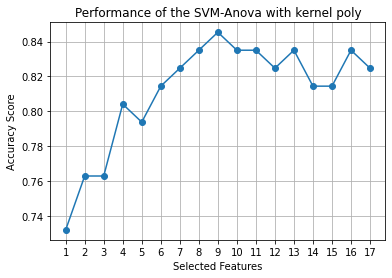

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score no selection: 0.7924379915305504
train score no selection: 0.8062283737024222
test score no selection: 0.8247422680412371

SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score selection: 0.7748941318814278
train score selection: 0.7647058823529411
test score selection: 0.7319587628865979

SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verb

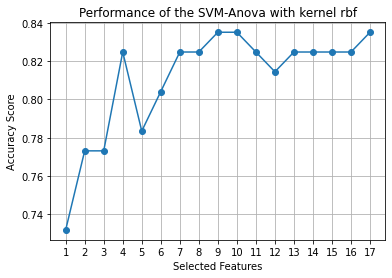

SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score no selection: 0.8027223230490019
train score no selection: 0.7854671280276817
test score no selection: 0.8144329896907216

SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score selection: 0.7645493042952208
train score selection: 0.7647058823529411
test score selection: 0.7319587628865979

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001,

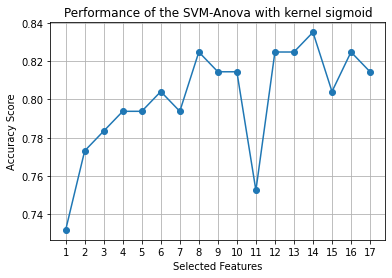

[(0.845360824742268, 9), (0.8350515463917526, 9), (0.8350515463917526, 14)]


In [3]:

'''best=5
selector = SelectKBest(f_classif, k=best)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.figure(figsize=(10, 5))
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')'''

param_search = [
                {'C': [0.01, 0.1, 1, 10, 100, 1000],
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4, 5]},
              {'C':[0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
                {'C': [0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'coef0': np.linspace(-10, 10, 5)}
]
kernels = ['poly', 'rbf', 'sigmoid']
best_scores = []
for i in range(len(param_search)):
  svm = GridSearchCV(SVC(kernel=kernels[i], class_weight='balanced'), param_search[i], cv=5, scoring='accuracy', refit=True)
  pipeline_not_sel = Pipeline([('scaler',  StandardScaler()),
                      ('clf_cv',svm)])
  pipeline_not_sel.fit(X_train, y_train)  
  cv_score = pipeline_not_sel[-1].best_score_
  m = pipeline_not_sel[-1].best_estimator_    
  print(m)     
  train_acc = pipeline_not_sel.score(X_train, y_train)
  test_acc = pipeline_not_sel.score(X_test, y_test)
  print("cv score no selection: {}".format(cv_score))
  print("train score no selection: {}".format(train_acc))
  print("test score no selection: {}\n".format(test_acc)) 

  pipeline_sel = Pipeline([('feature_sele',SelectKBest(f_classif)),
                        ('scaler',  StandardScaler()),
                      ('clf_cv',svm)])
  scores = []
  for best in X_indices[1:]:
    pipeline_sel.set_params(feature_sele__k=best)
    pipeline_sel.fit(X_train, y_train)
    cv_score = pipeline_sel[-1].best_score_
    m = pipeline_sel[-1].best_estimator_ 
    print(m)     
    support = pipeline_sel[0].get_support()
    train_acc = pipeline_sel.score(X_train, y_train)
    test_acc = pipeline_sel.score(X_test, y_test)
    print("cv score selection: {}".format(cv_score))
    print("train score selection: {}".format(train_acc))
    print("test score selection: {}\n".format(test_acc))
    scores.append(test_acc)
    if best == 5:
      print(X_indices[support])
  best_scores.append((max(scores), scores.index(max(scores))+1))
  plt.figure(figsize=(6, 4))
  plt.plot(X_indices[1:], scores, 'o-')
  plt.title(
      'Performance of the SVM-Anova with kernel '+kernels[i])
  plt.xticks(X_indices[1:])
  plt.xlabel('Selected Features')
  plt.ylabel('Accuracy Score')
  plt.axis('tight')
  plt.grid(True)
  plt.show()
  plt.close('all')

print(best_scores)
  
  

In [4]:
param_search = [
                {'C': [0.01, 0.1, 1, 10, 100, 1000],
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4, 5]},
              {'C':[0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
                {'C': [0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'coef0': np.linspace(-10, 10, 5)}
]
kernels = ['poly', 'rbf', 'sigmoid']
for i in range(len(param_search)):
  svm = GridSearchCV(SVC(kernel=kernels[i], class_weight='balanced'), param_search[i], cv=5, scoring='accuracy', refit=True)
  pipeline_not_sel = Pipeline([('scaler',  StandardScaler()),
                      ('clf_cv',svm)])
  pipeline_not_sel.fit(X_train, y_train)  
  cv_score = pipeline_not_sel[-1].best_score_
  m = pipeline_not_sel[-1].best_estimator_    
  print(m)     
  train_acc = pipeline_not_sel.score(X_train, y_train)
  test_acc = pipeline_not_sel.score(X_test, y_test)
  print("cv score no selection: {}".format(cv_score))
  print("train score no selection: {}".format(train_acc))
  print("test score no selection: {}\n".format(test_acc)) 

  pipeline_sel = Pipeline([('feature_sele',SelectKBest(f_classif, k=11)),
                        ('scaler',  StandardScaler()),
                      ('clf_cv',svm)])
  pipeline_sel.fit(X_train, y_train)
  cv_score = pipeline_sel[-1].best_score_
  m = pipeline_sel[-1].best_estimator_ 
  print(m)     
  support = pipeline_sel[0].get_support()
  train_acc = pipeline_sel.score(X_train, y_train)
  test_acc = pipeline_sel.score(X_test, y_test)
  print("cv score selection: {}".format(cv_score))
  print("train score selection: {}".format(train_acc))
  print("test score selection: {}\n".format(test_acc))
  scores.append(test_acc)
  print(X_indices[support])

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score no selection: 0.832620320855615
train score no selection: 0.9401197604790419
test score no selection: 0.8035714285714286

SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score selection: 0.8262032085561497
train score selection: 0.9700598802395209
test score selection: 0.8928571428571429

[ 0  2  3  4  5  7  8  9 11 12 16]
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=Non